# Common Imports

In [214]:
import os
import re
import pandas as pd
import numpy as np
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import utils as u

# Machine Learning Imports

In [215]:
import tensorflow as tf
import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn import ensemble
from sklearn import pipeline
from sklearn import linear_model
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import neural_network
from sklearn import feature_selection

# Set The Visual Style

In [216]:
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

# Set Hyperparameters

In [217]:
sample_size = 2
metrics = ['neg_mean_absolute_error', 'neg_median_absolute_error', 'r2', 'explained_variance', 'max_error']
cv = 3
random_seed = 42
var_threshold = 0.9
test_size = 0.3
preferred_score = 'r2'
tf.set_random_seed(random_seed)
missing_transport_factor = 1
min_outlier_factor = -2

# Import Data
## Main Dataset

In [218]:
queries = u.get_queries('queries')

In [219]:
bq_client = bigquery.Client()

In [220]:
data = u.get_data(queries, 'training_data.sql', bq_client)

In [221]:
data['post_code'] = data['address'].str.extract(r'.*(\d{4}).*', expand=False)

In [222]:
data = data.groupby('ad_id').apply(lambda obj: obj.sample(n=sample_size, random_state=random_seed) if len(obj) > sample_size else obj.sample(len(obj)))

## Norwegian Post Code Data

In [223]:
post_codes = u.get_data(queries, 'post_code_area_name.sql', bq_client).set_index('post_code', drop=True)

In [224]:
data = data.merge(post_codes, how='left', left_on='post_code', right_index=True)

In [225]:
data['address_oslo'] = data['settlement_name'].apply(lambda s_n: 1 if s_n == 'oslo' else 0)

In [226]:
new_building_pct = pd.Series(data[data.new_building == True]\
                             .groupby('area_name')['ad_id'].count()\
                             .div(data\
                                  .groupby('area_name')['ad_id'].count()),
                             name='area_new_building_pct')

data = data.merge(new_building_pct, how='left', left_on='area_name', right_index=True)

In [227]:
historic = pd.pivot_table(data=data, index='post_code', values='price_per_sq_m', aggfunc='median').rename(columns={'price_per_sq_m': 'median_price_per_sq_m'})
data = data.merge(historic, how='left', left_on='post_code', right_index=True)

# Google Maps Data

In [228]:
gmaps = u.get_data(queries, 'all_post_code_places.sql', bq_client)

In [229]:
place_counts = pd.pivot_table(data=gmaps, index='post_code', columns='place_type', values='attribute_value', aggfunc='count', fill_value=0)

In [230]:
_slice = gmaps[gmaps.place_attribute == 'rating']
place_ratings = pd.pivot_table(data=_slice, index='post_code', columns='place_type', values='attribute_value', aggfunc='mean')

In [231]:
_slice = gmaps[gmaps.place_attribute == 'price_level']
place_prices = pd.pivot_table(data=_slice, index='post_code', columns='place_type', values='attribute_value', aggfunc='mean')

In [232]:
gmaps_data = place_counts.join(place_ratings, rsuffix='_rating').join(place_prices, rsuffix='_price')

In [233]:
gmaps_data.dropna(axis=1, inplace=True)

In [234]:
data = data.merge(gmaps_data, how='left', left_on='post_code', right_index=True)

# National Health Institute Data

In [235]:
fhi_data = u.get_data(queries, 'full_fhi_data.sql', bq_client)

In [236]:
fhi_data_latest = pd.DataFrame(index=fhi_data.area_name.unique())
for dataset in fhi_data.dataset.unique():
    to_join = fhi_data[fhi_data.dataset == dataset]
    latest_year = to_join[to_join.value.notna()].year.max()
    to_join_latest_year = to_join[to_join.year == latest_year]
    to_join_pivot = pd.pivot_table(data=to_join_latest_year,
                                   index='area_name',
                                   values='value').rename(columns={'value': dataset})
    fhi_data_latest = fhi_data_latest.join(to_join_pivot)

In [237]:
fhi_data_latest.head()

,income_inequality,uni_graduates,low_income_households,cramped_spaces,immigrant_pct
hurdal,0.025,0.35,0.168,0.128,0.103
st.hanshaugen,0.038,0.73,0.186,0.469,0.278
frogner,0.047,0.72,0.160,0.328,0.280
ullern,0.040,0.76,0.066,0.160,0.199
vestre aker,0.045,0.77,0.069,0.140,0.178


In [238]:
fhi_cols = list(fhi_data_latest.columns)

In [239]:
data = data.merge(fhi_data_latest, how='left', left_on='area_name', right_index=True)

# Impute Data

In [240]:
data.isna().sum(axis=0).sort_values(ascending=False)[:10]

apt_id                   1824
floor                     628
num_bedrooms               74
area_new_building_pct      37
time_s                     29
immigrant_pct               7
low_income_households       7
uni_graduates               7
income_inequality           7
cramped_spaces              7
dtype: int64

In [241]:
data['time_s'].fillna(data['time_s'].max() * missing_transport_factor, inplace=True)
data['floor'].fillna(1, inplace=True)
data['num_bedrooms'].fillna(0, inplace=True)
data['median_price_per_sq_m'].fillna(data.median_price_per_sq_m.median(), inplace=True)
data['uni_graduates'].fillna(data.uni_graduates.mean(), inplace=True)
data['area_new_building_pct'] = data.area_new_building_pct.fillna(data.area_new_building_pct.mean())
data.fillna(0, inplace=True)

In [242]:
data.drop(['address', 'post_code', 'area_name', 'settlement_name', 'ad_id', 'apt_id'], axis=1, inplace=True)

In [243]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2559 entries, (69757913, 5512) to (153395022, 4924)
Columns: 120 entries, time_s to immigrant_pct
dtypes: float64(116), int64(4)
memory usage: 2.4 MB


# Select For Variance

In [244]:
X = data.drop('price_per_sq_m', axis=1)
y = data['price_per_sq_m']

In [245]:
var_estimator = feature_selection.VarianceThreshold(threshold=var_threshold)
var_estimator.fit(X)
variances = pd.Series(var_estimator.variances_, index=X.columns)

In [246]:
variances.sort_values(ascending=False).head(10)

median_price_per_sq_m    4.535645e+08
time_s                   3.865628e+06
primary_size             2.759905e+03
construction_year        1.618623e+03
point_of_interest        3.046414e+01
establishment            3.046414e+01
food                     1.044830e+01
restaurant               9.961640e+00
store                    6.880697e+00
lodging                  3.721903e+00
dtype: float64

In [247]:
var_features = pd.Series(var_estimator.get_support(), index=X.columns, name='var_features')

In [248]:
var_features.head()

time_s                      True
property_type_apartment    False
new_building               False
construction_year           True
ownership_full             False
Name: var_features, dtype: bool

# Detect Outliers

In [249]:
outlier_detector = neighbors.LocalOutlierFactor(contamination=0.22)
outlier_detector.fit(data)
data['neg_outlier_factor'] = outlier_detector.negative_outlier_factor_

In [250]:
data['neg_outlier_factor'].describe()

count    2559.000000
mean       -1.103727
std         0.294892
min        -6.832577
25%        -1.107767
50%        -1.043348
75%        -1.004057
max        -0.949989
Name: neg_outlier_factor, dtype: float64

In [251]:
data = data[data.neg_outlier_factor > min_outlier_factor].copy()

In [252]:
print('The number of identified outliers is: {}'.format(data[data.neg_outlier_factor <= min_outlier_factor].shape[0]))

The number of identified outliers is: 0


In [253]:
data.drop('neg_outlier_factor', axis=1, inplace=True)

# Define Model

In [254]:
def create_model():
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [255]:
estimators = {'deep_learning_regressor': KerasRegressor(build_fn=create_model, epochs=700, batch_size=700, verbose=False),
              'adaboost': ensemble.AdaBoostRegressor(random_state=random_seed),
              'linear': linear_model.LinearRegression(),
              'kneighbors': neighbors.KNeighborsRegressor(),
              'bayes': naive_bayes.ComplementNB(),
              'mlp': neural_network.MLPRegressor(random_state=random_seed)}

In [256]:
estimator = estimators['adaboost']

In [257]:
steps = [('scale', preprocessing.MinMaxScaler()),
         ('normalize', preprocessing.Normalizer()),
         ('estimator', estimator)]

In [258]:
model = pipeline.Pipeline(steps)

# Split Data

In [259]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                                    test_size=test_size,
                                                                    random_state=random_seed)

In [260]:
X_train.shape

(1791, 119)

# Recursive Feature Elimination

In [261]:
rfe = feature_selection.RFECV(estimator, step=1, cv=model_selection.KFold(cv), scoring='neg_median_absolute_error')

In [262]:
rfe.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
      estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                  loss='linear', n_estimators=50,
                                  random_state=42),
      min_features_to_select=1, n_jobs=None,
      scoring='neg_median_absolute_error', step=1, verbose=0)

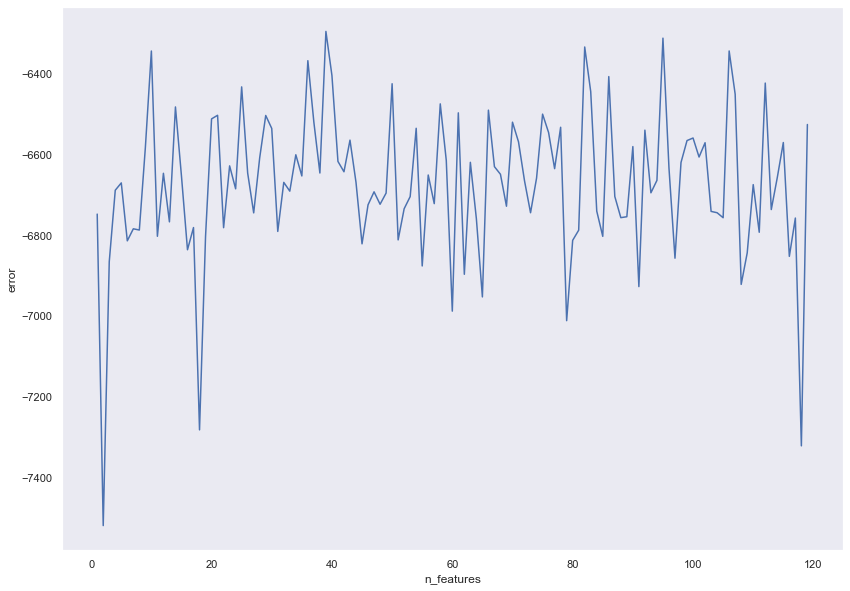

In [263]:
plt.figure()
plt.xlabel('n_features')
plt.ylabel('error')
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [264]:
optimal_n_features = rfe.grid_scores_.argmax() + 1
print(f'The optimal number of features is: {optimal_n_features}')

The optimal number of features is: 39


In [265]:
feature_ranking = pd.Series(rfe.ranking_, index=X.columns)

In [266]:
feature_ranking.sort_values()

time_s                     1
furniture_store            1
low_income_households      1
health                     1
zoo                        1
hospital                   1
uni_graduates              1
parking                    1
pet_store                  1
pharmacy                   1
physiotherapist            1
electronics_store          1
place_of_worship           1
police                     1
political                  1
premise                    1
real_estate_agency         1
restaurant                 1
school                     1
store                      1
travel_agency              1
university                 1
veterinary_care            1
point_of_interest          1
church                     1
                          ..
shopping_mall             57
establishment             58
taxi_stand                59
sublocality               60
lawyer                    61
fire_station              62
laundry                   63
gas_station               64
florist       

## Select Optimal Features

In [267]:
high_variance_features = list(var_features[var_features == True].index)
top_rank_features = list(feature_ranking[feature_ranking <= feature_ranking.describe()['25%']].index)

In [268]:
selected_features = list(set(high_variance_features + top_rank_features))

In [269]:
X_train = X_train[selected_features].copy()
X_test = X_test[selected_features].copy()

# Fit Model

In [270]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('normalize', Normalizer(copy=True, norm='l2')),
                ('estimator',
                 AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                   loss='linear', n_estimators=50,
                                   random_state=42))],
         verbose=False)

In [271]:
pred = model.predict(X_test)

In [272]:
y_pred = pd.Series(pred, index=y_test.index, name='predicted')

# Draw Learning Curves

In [273]:
def get_learning_curves(estimator, X, y, train_sizes=np.arange(0.1, 1.1, 0.1), score='neg_mean_absolute_error', cv=5):
    train_sizes, train_scores, test_scores = model_selection.learning_curve(estimator, X, y, train_sizes=train_sizes, scoring=score, cv=cv)
    curve_data = pd.DataFrame(columns = range(train_scores.shape[1]))
    for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
        frame = pd.DataFrame(result)
        frame['size'] = train_sizes
        frame['type'] = result_type
        curve_data = curve_data.append(frame, ignore_index = True)
    curve_data = curve_data.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')
    return curve_data


def get_cv_res(estimator, X, y, score=['neg_mean_absolute_error'], cv=5):
    cross_val = model_selection.cross_validate(estimator, X, y, scoring=score, cv=cv)
    return cross_val


def print_cv_res(cross_val):
    for key, val in cross_val.items():
        print('Mean {}, {:.2f}'.format(key, val.mean()))

In [274]:
learning_curve_res = get_learning_curves(model, X_train, y_train, score='neg_median_absolute_error')

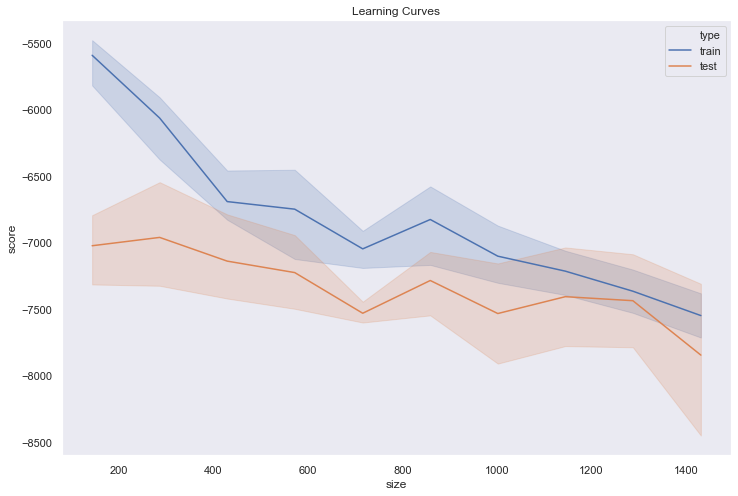

In [275]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
plt.show()

# Display Cross-Validation Results

In [276]:
cv_res = get_cv_res(model,
                    X_train[selected_features],
                    y_train,
                    score=['neg_median_absolute_error',
                           'r2',
                           'explained_variance',
                           'max_error'],
                    cv=cv)

In [277]:
print_cv_res(cv_res)

Mean fit_time, 0.16
Mean score_time, 0.02
Mean test_neg_median_absolute_error, -7792.78
Mean test_r2, 0.72
Mean test_explained_variance, 0.74
Mean test_max_error, -73379.44


## Display Predicted VS Actual

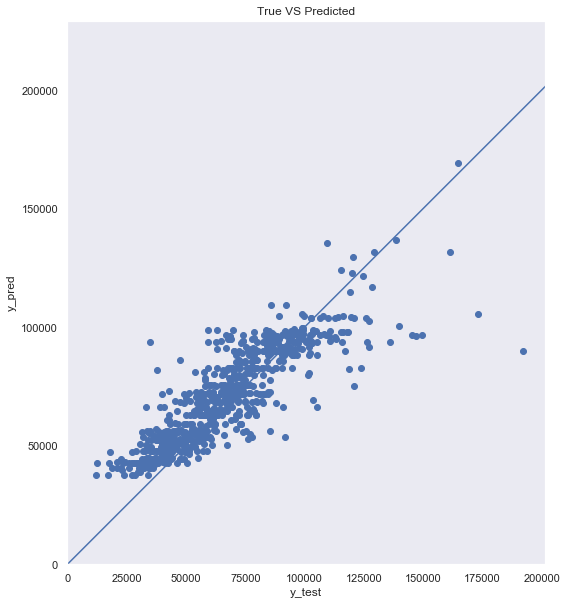

In [278]:
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-5e7, 5e7], [-5e7, 5e7])
plt.title('True VS Predicted')
plt.show()

## Display Error Spread

In [279]:
to_plot = X_test.join(y_pred).join(y_test)
to_plot['pred_diff'] = to_plot['predicted'] - to_plot['price_per_sq_m']

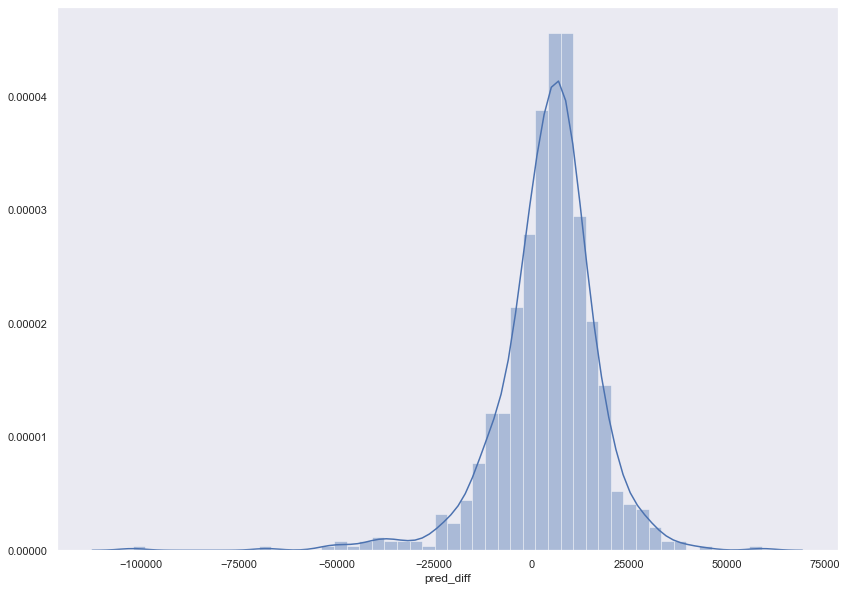

In [280]:
sns.distplot(to_plot.pred_diff)
plt.show()

# Display Feature Importances

In [281]:
feature_importances = pd.Series(model.named_steps['estimator'].feature_importances_, index=selected_features).sort_values(ascending=True)

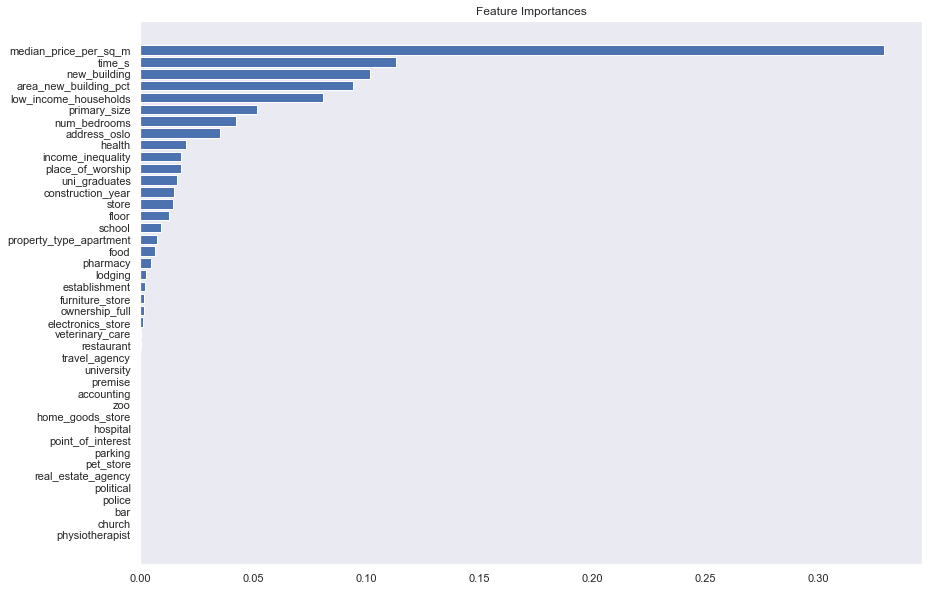

In [282]:
to_plot = feature_importances
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

In [283]:
feature_importances.to_frame(name='importance').style.format('{:.1%}')

,importance
physiotherapist,0.0%
church,0.0%
bar,0.0%
police,0.0%
political,0.0%
real_estate_agency,0.0%
pet_store,0.0%
parking,0.0%
point_of_interest,0.0%
hospital,0.0%


# TODO
* Draw learning curves on multiple metrics
* Produce statistics for all types of models
* Select final model
* Tune up the final model
* Deploy model to cloud